# Упражнение Мультиклассовая Support Vector Machine

В этом упражнении вы:
    
- реализуете полностью векторизированную **функцию потерь** для SVM;
- реализуете полностью векторизированное выражение для её **аналитического градиента**;
- **проверите свою реализацию**, используя числовой градиент;
- будете использовать валидационный набор для **настройки скорости обучения и силы регуляризации**;
- **оптимизируете** функцию потерь с помощью **SGD**;
- **визуализируете** итоговые обученные веса.

In [1]:
# Запустим установочный код для этого ноутбука.

import os

import numpy as np
import matplotlib.pyplot as plt

from cs231n.data_utils import load_CIFAR10

# Немного магии, позволяющей отображать matplotlib-рисунки в ноутбуке, а не в новом окне.
%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # установим размер графиков по умолчанию
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

# Ещё немного магии, чтобы ноутбук перезагрузил внешние модули Python;
# Смотри http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Загрузка и предварительная обработка набора CIFAR-10

In [2]:
# Загрузим необработанный набор данных CIFAR-10.
cifar10_dir = os.path.join("cs231n", "datasets", "cifar-10-batches-py")

# Очистка переменных для предотвращения многократной загрузки данных (что может вызвать проблемы с памятью).
try:
    del X_train, y_train
    del X_test, y_test
    print("Ранее загруженные данные очищены.")
except:
    pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# В качестве проверки работоспособности мы распечатываем размер обучающих и тестовых данных.
print("Форма обучающих данных:", X_train.shape)
print("Форма обучающих меток: ", y_train.shape)
print("Форма тестовых данных: ", X_test.shape)
print("Форма тестовых меток:  ", y_test.shape)

Форма обучающих данных: (50000, 32, 32, 3)
Форма обучающих меток:  (50000,)
Форма тестовых данных:  (10000, 32, 32, 3)
Форма тестовых меток:   (10000,)


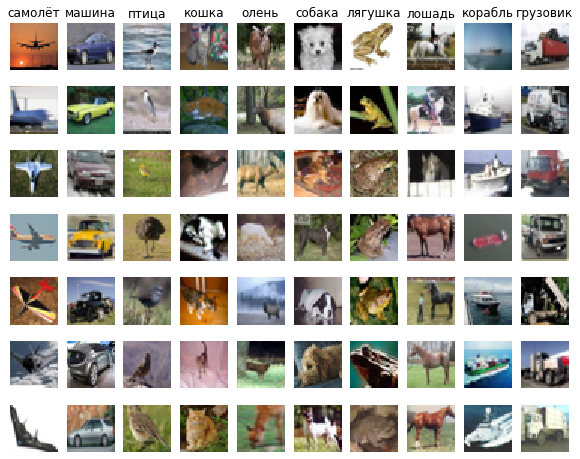

In [3]:
# Визуализируем несколько примеров из набора данных.
# Мы показываем несколько примеров обучающих изображений из каждого класса.
classes = ["самолёт", "машина", "птица", "кошка", "олень", "собака", "лягушка", "лошадь", "корабль", "грузовик"]
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype("uint8"))
        plt.axis("off")
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Разделим набор данных на обучающую, валидационную и тестовую части.
# Кроме того, мы создадим небольшой набор для разработки как подмножество
# обучающих данных; мы можем использовать его для разработки, чтобы наш
# код работал быстрее.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Наша валидационная часть будет состоять из num_validation точек данных
# из исходного обучающего набора.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Наша обучающая часть будет состоять из первых num_train точек данных
# из исходного обучающего набора.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# Мы также создаём набор данных для разработки, который является
# подвыборкой из новой обучающей части.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# Мы используем первые num_test точки данных из исходного тестового набора
# в качестве нашей тестовой части.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print("Форма обучающих данных:     ", X_train.shape)
print("Форма обучающих меток:      ", y_train.shape)
print("Форма валидационных данных: ", X_val.shape)
print("Форма валидационных меток:  ", y_val.shape)
print("Форма тестовых данных:      ", X_test.shape)
print("Форма тестовых меток:       ", y_test.shape)
print("Форма данных для разработки:", X_dev.shape)
print("Форма меток для разработки: ", y_dev.shape)

Форма обучающих данных:      (49000, 32, 32, 3)
Форма обучающих меток:       (49000,)
Форма валидационных данных:  (1000, 32, 32, 3)
Форма валидационных меток:   (1000,)
Форма тестовых данных:       (1000, 32, 32, 3)
Форма тестовых меток:        (1000,)
Форма данных для разработки: (500, 32, 32, 3)
Форма меток для разработки:  (500,)


In [5]:
# Предобработка: преобразуем изображения в векторы-строки
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# В качестве проверки мы распечатываем размер обучающих и тестовых данных.
print("Форма обучающих данных:     ", X_train.shape)
print("Форма обучающих меток:      ", X_val.shape)
print("Форма тестовых данных:      ", X_test.shape)
print("Форма данных для разработки:", X_dev.shape)

Форма обучающих данных:      (49000, 3072)
Форма обучающих меток:       (1000, 3072)
Форма тестовых данных:       (1000, 3072)
Форма данных для разработки: (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


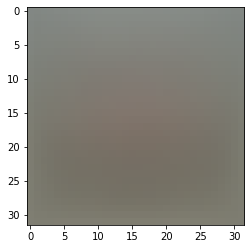

Форма обучающих данных:      (49000, 3073)
Форма обучающих меток:       (1000, 3073)
Форма тестовых данных:       (1000, 3073)
Форма данных для разработки: (500, 3073)


In [6]:
# Предобработка: вычитание среднего арифметического изображения
# Во-первых: вычислим среднее арифметическое изображение по обучающей части
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10])  # распечатаем несколько элементов
plt.figure(figsize=(4, 4))
plt.imshow(mean_image.reshape((32, 32, 3)).astype("uint8"))  # визуализируем среднее арифметическое изображение
plt.show()

# Во-вторых: вычтем среднее арифметического изображение из обучающих и тестовых данных
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# В-третьих: добавим размерность смещения, заполненную единицами (т.е. трюк со смещением),
# таким образом, чтобы наша SVM беспокоилась только об оптимизации единой матрицы весов W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print("Форма обучающих данных:     ", X_train.shape)
print("Форма обучающих меток:      ", X_val.shape)
print("Форма тестовых данных:      ", X_test.shape)
print("Форма данных для разработки:", X_dev.shape)

## SVM-классификатор

Для этого раздела вы будете писать код в `cs231n/classifiers/svm.py`. 

Как вы можете видеть, мы предварительно написали функцию `svm_loss_naive`, которая использует циклы `for` для оценки функции потерь мультиклассовой SVM. 

In [7]:
# Оцените наивную реализацию функции потерь, которую мы вам предоставили:
from cs231n.classifiers.svm import svm_loss_naive


# сгенерируем случайную весовую матрицу SVM из небольших чисел
W = np.random.randn(3073, 10) * 0.0001

loss, _ = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print("Потеря: %f." % loss)

Потеря: 9.152462.


`grad`, возвращаемый приведённой выше функцией сейчас состоит из нулей. Выведите и реализуйте вычисление аналитического градиента для функции потерь SVM в функции `svm_loss_naive`. Вам будет полезно чередовать ваш новый код внутри существующей функции.

Чтобы убедиться, что вы правильно реализовали вычисление градиента, вы можете численно оценить градиент функции потерь и сравнить численную оценку с вычисленным вами градиентом. Мы предоставили код, который делает это за вас:

In [8]:
# Как только вы реализовали вычисление аналитического градиента, пересчитайте
# его с помощью кода ниже и осуществите проверку градиента с помощью функции,
# которую мы вам предоставили.

# Вычислите потери и их градиент при W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Вычислим численный градиент по нескольким случайно выбранным измерениям и
# сравним его с вашим вычисленным аналитическим градиентом. Они должны почти
# точно совпадать по всем измерениям.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# Ещё раз проверим градиент с включенной регуляризацией. Вы не забыли
# регуляризацию градиента, не так ли?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

Проверка началась.
Численный: 28.503925, аналитический: 28.503925, относительная ошибка: 5.656886e-12
Численный: 1.313184, аналитический: 1.313184, относительная ошибка: 3.106059e-10
Численный: -20.142075, аналитический: -20.142075, относительная ошибка: 1.289507e-11
Численный: 1.741934, аналитический: 1.741934, относительная ошибка: 7.610280e-11
Численный: -20.068963, аналитический: -20.068963, относительная ошибка: 1.870635e-11
Численный: 3.855966, аналитический: 3.855966, относительная ошибка: 6.574950e-11
Численный: -11.799196, аналитический: -11.799196, относительная ошибка: 1.591702e-11
Численный: 8.568434, аналитический: 8.568434, относительная ошибка: 2.372316e-11
Численный: -28.382646, аналитический: -28.382646, относительная ошибка: 6.516895e-12
Численный: -15.531509, аналитический: -15.531509, относительная ошибка: 3.650413e-11
Проверка закончилась.
Проверка началась.
Численный: -0.181172, аналитический: -0.181172, относительная ошибка: 1.201568e-09
Численный: 3.033437, анал

In [9]:
# Далее реализуйте функцию svm_loss_vectorized; пока только вычисление потери;
# мы реализуем вычисление градиента в один миг.
import time
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print("Наивная потеря:         %e вычислена за %fs секунд." % (loss_naive, toc - tic))

from cs231n.classifiers.svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print("Векторизованная потеря: %e вычислена за %fs секунд." % (loss_vectorized, toc - tic))

# Потери должны совпадать, но ваша векторизованная реализация должна быть намного быстрее.
print("Разница: %f." % (loss_naive - loss_vectorized))

Наивная потеря:         9.152462e+00 вычислена за 0.161899s секунд.
Векторизованная потеря: 9.152462e+00 вычислена за 0.005999s секунд.
Разница: 0.000000.


In [10]:
# Завершите реализацию svm_loss_vectorized и вычислите градиент функции потерь
# векторизованным способом.

# Наивная реализация и векторизованная реализация должны совпадать, но
# векторизованная версия также должна быть намного быстрее.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print("Наивная потеря и градиент вычислены за %fs секунд." % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print("Векторизованная потеря и градиент вычислены за %fs секунд." % (toc - tic))

# Потеря представляет собой одно число, поэтому легко сравнить значения,
# вычисленные двумя реализациями. Градиент, с другой стороны, является
# матрицей, поэтому мы используем норму Фробениуса для их сравнения.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord="fro")
print("Разница: %f." % difference)

Наивная потеря и градиент вычислены за 0.171489s секунд.
Векторизованная потеря и градиент вычислены за 0.006998s секунд.
Разница: 0.000000.


### Стохастический Градиентный Спуск

Теперь у нас есть векторизованные и эффективные выражения для потерь, градиента, и наш градиент соответствует числовому градиенту. Следовательно мы готовы сделать SGD, чтобы минимизировать потери. Ваш код для этой части будет написан внутри `cs231n/classifiers/linear_classifier.py`.

In [11]:
# В файле linear_classifier.py, реализуйте SGD в методе LinearClassifier.train(),
# а затем запустите его с помощью приведённого ниже кода.
from cs231n.classifiers import SVM
svm = SVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print("Это заняло %fs секунд." % (toc - tic))

итерация 0/1500: потеря 787.870801
итерация 100/1500: потеря 285.357341
итерация 200/1500: потеря 107.506748
итерация 300/1500: потеря 42.115017
итерация 400/1500: потеря 18.993039
итерация 500/1500: потеря 10.151326
итерация 600/1500: потеря 7.036389
итерация 700/1500: потеря 5.820103
итерация 800/1500: потеря 5.803106
итерация 900/1500: потеря 5.244397
итерация 1000/1500: потеря 4.894352
итерация 1100/1500: потеря 5.228885
итерация 1200/1500: потеря 5.131515
итерация 1300/1500: потеря 5.006189
итерация 1400/1500: потеря 5.198656
Это заняло 8.294932s секунд.


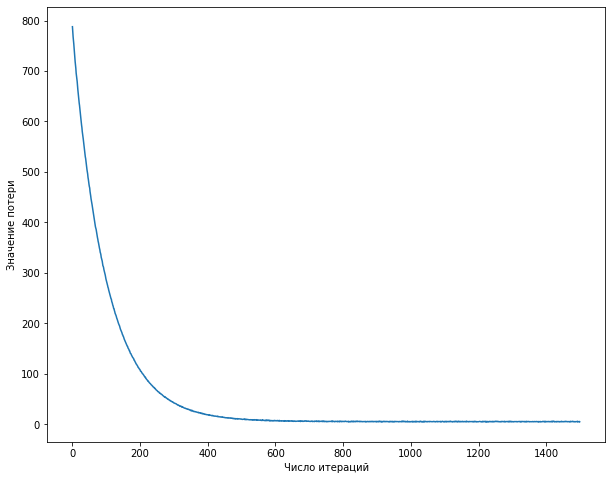

In [12]:
# Полезной стратегией отладки является построение
# графика потерь в зависимости от числа итераций:
plt.plot(loss_hist)
plt.xlabel("Число итераций")
plt.ylabel("Значение потери")
plt.show()

In [13]:
# Реализуйте метод SVM.predict() и оцените производительность
# и на обучающем, и на валидационном наборе
y_train_pred = svm.predict(X_train)
print("Точность на обучающем наборе: {:2.2%}.".format(np.mean(y_train == y_train_pred)))
y_val_pred = svm.predict(X_val)
print("Точность на валидационном наборе: {:2.2%}.".format(np.mean(y_val == y_val_pred)))

Точность на обучающем наборе: 37.14%.
Точность на валидационном наборе: 38.90%.


In [14]:
# Используйте валидационный набор для настройки гиперпараметров (силы
# регуляризации и скорости обучения). Вам следует поэкспериментировать с
# различными диапазонами для скорости обучения и силы регуляризации; если вы
# постараетесь, вы сможете получить точность классификации около 0,39 для
# валидационного набора.

# Примечание: Во время поиска по гиперпараметрам могут появляться предупреждения
# о времени выполнения / переполнении. Это может быть вызвано предельными
# значениями и не является ошибкой.

# Результаты в словаре - это сопоставление кортежей формой (скорость обучения,
# сила регуляризации) с кортежами формой (точность на обучающем наборе,
# точность на валидационном наборе). Точность - это просто доля правильно
# классифицированных точек данных.
results = {}
# Самая высокая точность на валидационном наборе, которую мы видели до сих пор.
best_val_accuracy = -1
# Объект LinearSVM, достигший наивысшей точность на валидационном наборе.
best_svm = None

# ***************************** ЗАДАНИЕ ***************************** #
# Напишите код, который выбирает лучшие гиперпараметры, при настройке #
# на валидационном наборе. Для каждой комбинации гиперпараметров,     #
# обучите LinearSVM на обучающем наборе, посчитайте его точность на   #
# обучающем и валидационном наборах и сохраните эти числа в словаре   #
# results. Кроме того, сохраните лучшую точность на валидационном     #
# наборе в best_val и объект LinearSVM, который обеспечивает эту      #
# точность в best_svm.                                                #
#                                                                     #
# ПОДСКАЗКА: Вам следует использовать малые значения num_iters при    #
# разработке вашего валидационного кода, чтобы обучение LinearSVM'ов  #
# не занимало много времени; как только вы убедитесь, что ваш         #
# валидационный код работает, вам следует перезапустить его с         #
# большими значениями num_iters.                                      #

# Предоставляется для примера. Вы можете изменить эти гиперпараметры,
# а можете и не менять.
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# ************************ НАЧАЛО МОЕГО КОДА ************************ #
NUM_TRIES = 100
# Перебор значений для скорости обучения и силы регуляризации не по сетке,
# а по случайному распределению.
for _ in range(NUM_TRIES):
    # выбираем значение скорости обучения случайным образом из заданного диапазона
    lr = np.random.uniform(learning_rates[0], learning_rates[1])
    # выбираем значение силы регуляризации случайным образом из заданного диапазона
    rs = np.random.uniform(regularization_strengths[0], regularization_strengths[1])
    
    # создаём новый экземпляр класса LinearSVM
    svm = SVM()
    # обучаем его
    svm.train(X_train, y_train, learning_rate=lr, reg=rs, verbose=False)
    
    # получаем предсказания для обучающей части
    y_train_pred = svm.predict(X_train)
    # вычисляем точность для обучающей части
    train_accuracy = np.mean(y_train_pred == y_train)
        
    # получаем предсказания для валидационной части
    y_val_pred = svm.predict(X_val)
    # вычисляем точность для валидационной части
    val_accuracy = np.mean(y_val_pred == y_val)
    
    # сохраняем результаты    
    results[(lr, rs)] = (train_accuracy, val_accuracy)
    if best_val_accuracy < val_accuracy:
        best_val_accuracy = val_accuracy
        best_svm = svm
# ************************ КОНЕЦ МОЕГО КОДА ************************* #
    
# Распечатаем результаты
for lr, rs in sorted(results):
    train_accuracy, val_accuracy = results[(lr, rs)]
    print("Скорость обучения: %e.      Силы регуляризации %e." % (lr, rs))
    print("Точность на обучающем наборе: {:2.2%}. Точность на валидационном наборе: {:2.2%}.".format(
        train_accuracy, val_accuracy)
    )
    print("-------------------------------------------------------------------------------")
    
print("Лучшая точность на валидационном наборе: {:2.2%}".format(best_val_accuracy))

Скорость обучения: 7.138926e-07.      Силы регуляризации 3.385607e+04.
Точность на обучающем наборе: 31.56%. Точность на валидационном наборе: 32.30%.
-------------------------------------------------------------------------------
Скорость обучения: 7.971114e-07.      Силы регуляризации 4.119898e+04.
Точность на обучающем наборе: 28.00%. Точность на валидационном наборе: 27.60%.
-------------------------------------------------------------------------------
Скорость обучения: 1.156035e-06.      Силы регуляризации 3.492701e+04.
Точность на обучающем наборе: 28.17%. Точность на валидационном наборе: 29.30%.
-------------------------------------------------------------------------------
Скорость обучения: 1.172421e-06.      Силы регуляризации 4.050922e+04.
Точность на обучающем наборе: 25.49%. Точность на валидационном наборе: 26.10%.
-------------------------------------------------------------------------------
Скорость обучения: 1.201668e-06.      Силы регуляризации 2.817778e+04.
Точно

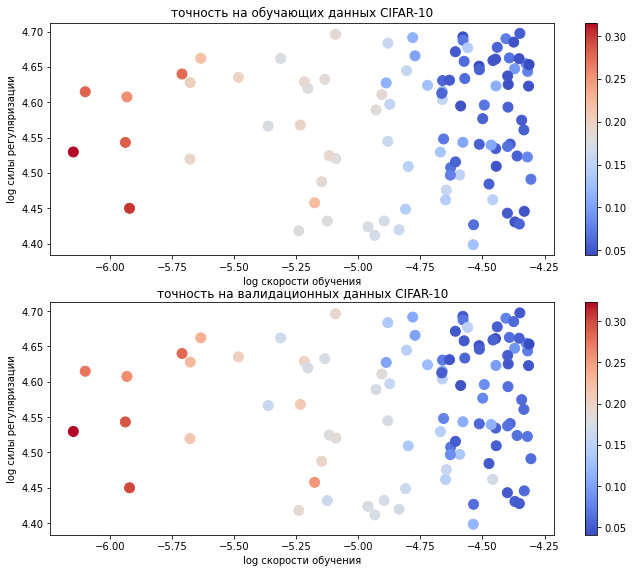

In [15]:
# Визуализируем результаты валидации
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# отобразим точность на обучающей части
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel("log скорости обучения")
plt.ylabel("log силы регуляризации")
plt.title("точность на обучающих данных CIFAR-10")

# отобразим точность на валидационной части
colors = [results[x][1] for x in results]  # размер маркеров по умолчанию-20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel("log скорости обучения")
plt.ylabel("log силы регуляризации")
plt.title("точность на валидационных данных CIFAR-10")
plt.show()

In [16]:
# Оценим лучший SVM на тестовом наборе
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print("Окончательная оценка точности линейной SVM на тестовой части: {:2.2%}.".format(test_accuracy))

Окончательная оценка точности линейной SVM на тестовой части: 31.00%.


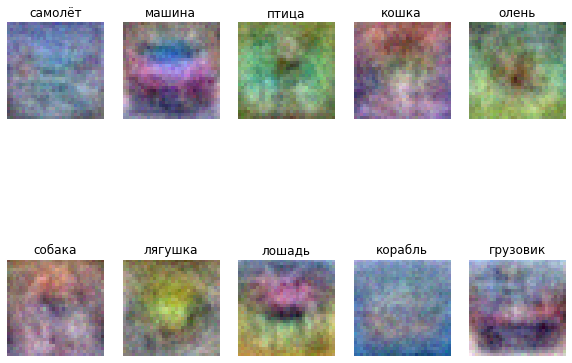

In [17]:
# Визуализируем обученные веса каждого класса.
w = best_svm.W[:-1, :]  # отбросим смещение
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ["самолёт", "машина", "птица", "кошка", "олень", "собака", "лягушка", "лошадь", "корабль", "грузовик"]
for i in range(10):
    plt.subplot(2, 5, i + 1)
    # Изменим значения весов до диапазона от 0 до 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype("uint8"))
    plt.axis("off")
    plt.title(classes[i])